In [1]:
import dill as pickle
import numpy as np
from PIL import Image
from pathlib import Path
from torchvision import transforms
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from src.dataset import ImageDS, BorderPredictionDS, Testset, denorm
from src.utils import my_collate

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
testset_path = "files/challenge_testset/testset.pkl"
model_path = "results/best_model.pt"
image_stats_path = "files/image_stats.pkl"
validation_file_path = "files/challenge_testset/testset_submission_random.pkl"
outfile = "data/submission.pkl"

In [4]:
with open(image_stats_path, "rb") as f:
    mean, std = pickle.load(f)

In [5]:
batch_size = 16

net = torch.load(model_path)
net.eval()

BorderPredictionNet(
  (cnn): CNNBase(
    (hidden_layers): Sequential(
      (0): ConvAuto(2, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (1): ReLU(inplace=True)
      (2): ConvAuto(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (3): ReLU(inplace=True)
      (4): ConvAuto(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (5): ReLU(inplace=True)
    )
    (output_layer): ConvAuto(64, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  )
)

In [6]:
ds_test = Testset(testset_path, mean, std)
#ds_test = Testset("data/my_testset_dict.pkl", mean, std)
dl_test = DataLoader(ds_test, batch_size=16, num_workers=4, shuffle=False)

In [7]:
pred_list = []
for x, mask in dl_test:
    pred_ = net.cnn(x.to(device)).detach().squeeze(1).cpu()
    pred = torch.round(denorm(pred_, mean, std)).numpy().astype("uint8")
    pred_list.extend([p[~m] for p, m in zip(pred, mask)])

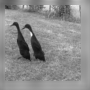

In [8]:
# TEST PREDICTIONS
idx = 25

orig = ds_test.data["input_arrays"][idx]
mask = ~ds_test.data["known_arrays"][idx].astype(bool)
pred = pred_list[idx]
orig[mask] = pred
im = Image.fromarray(orig)
im.show()

In [9]:
# verify prediction shapes
with open(validation_file_path, "rb") as f:
    testset_submission = pickle.load(f)

sum([len(x)!=len(y) for x,y in zip(pred_list, testset_submission)])

0

In [10]:
with open(outfile, "wb") as f:
    pickle.dump(pred_list, f)